Import Libraries

In [7]:
import numpy as np
import pandas as pd
import nltk
import re
from matplotlib import pyplot
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import string

Import dataset and assign column names

In [8]:
#Upload Dataset as DataFrame and split csv data into label and body text columnes
RawData=pd.read_csv('smsspamCollection.tsv',sep='\t',header=None)

#Assign column names
RawData.columns=['label', 'body_text']

Checking dataset dimensions and missing values if any 

In [9]:
#Dataset dimension
print('The dataset has {} raws and {} columns'.format(len(RawData),len(RawData.columns)))
#determining missing values
print('The the number of missing labels is {}'.format(RawData['label'].isna().sum()))
print('The the number of missing body text is {}'.format(RawData['body_text'].isna().sum()))

The dataset has 5568 raws and 2 columns
The the number of missing labels is 0
The the number of missing body text is 0


In [10]:
#determining dataset is balanced?
RawData['label'].value_counts()

ham     4822
spam     746
Name: label, dtype: int64

C:\Users\Arup\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\Arup\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


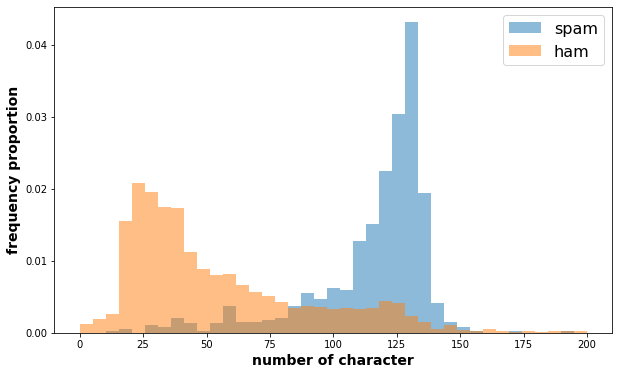

In [11]:
#Creating new features: number of letters and other character
X1=RawData['body_text'].apply(lambda x: len(x)-x.count(" "))

#feature evaluation 'word_count'
pyplot.figure(figsize=(10, 6))
bins=np.linspace(0,200,40)
pyplot.hist(X1[RawData['label']=='spam'],bins,alpha=0.5,normed=True,label='spam')
pyplot.hist(X1[RawData['label']=='ham'],bins,alpha=0.5,normed=True,label='ham')
pyplot.legend(loc='upper left')
pyplot.legend(fontsize=16)
pyplot.xlabel('number of character', fontsize=14, fontweight='bold')
pyplot.ylabel('frequency proportion', fontsize=14, fontweight='bold')

pyplot.savefig('C:/Users/Arup/Downloads/word_count.png', dpi=1200, bbox_inches='tight')
#X_RawData['word_count']=pd.DataFrame(scaler.fit_transform(X_RawData[['word_count']]))

C:\Users\Arup\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
C:\Users\Arup\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


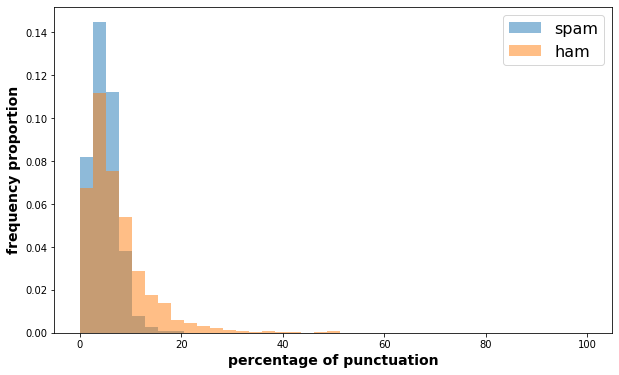

In [12]:
#Creating new features: proportions of punctuation
def count_punctuation(text):
    punc=[char for char in text if char in string.punctuation]
    return len(punc)

#use +1 in denominator to avoid ZeroDivisionError 
X2=RawData['body_text'].apply(lambda x: round(count_punctuation(x)/(1+len(x)-x.count(" ")),3)*100)

#feature evaluation 'word_count'
pyplot.figure(figsize=(10, 6))
bins=np.linspace(0,100,40)
pyplot.hist(X2[RawData['label']=='spam'],bins,alpha=0.5,normed=True,label='spam')
pyplot.hist(X2[RawData['label']=='ham'],bins,alpha=0.5,normed=True,label='ham')
pyplot.legend(loc='upper left')
pyplot.legend(fontsize=16)
pyplot.xlabel('percentage of punctuation', fontsize=14, fontweight='bold')
pyplot.ylabel('frequency proportion', fontsize=14, fontweight='bold')

pyplot.savefig('C:/Users/Arup/Downloads/punc_prop.png', dpi=1200, bbox_inches='tight')

In [14]:
from scipy.stats import pointbiserialr
correlation, p_value = pointbiserialr(X1, RawData['label'].map({'spam': 0, 'ham': 1}))
print("Point-Biserial Correlation for X1:", correlation)
print("P-Value:", p_value)

from scipy.stats import pointbiserialr
correlation, p_value = pointbiserialr(X2, RawData['label'].map({'spam': 0, 'ham': 1}))
print("Point-Biserial Correlation for X2:", correlation)
print("P-Value:", p_value)

Point-Biserial Correlation for X1: -0.40237001732467953
P-Value: 8.996905971530643e-216
Point-Biserial Correlation for X2: 0.13106449068183842
P-Value: 9.225588403688239e-23


In [15]:
#Convert all text to lowercase
RawData['body_text']=RawData['body_text'].apply(lambda x: x.lower())

In [16]:
#remove pantuation and special characters
def remove_punctuation(text):
    no_punc="".join([char for char in text if char not in string.punctuation])
    return no_punc

RawData['body_text']=RawData['body_text'].apply(lambda x: remove_punctuation(x))

In [17]:
#remove numbers
RawData['body_text']=RawData['body_text'].apply(lambda x: re.sub(r'\d+', '', x))

In [18]:
#tokenize
RawData['body_text']=RawData['body_text'].apply(lambda x: word_tokenize(x))

In [19]:
#remove stop words
stopword=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    no_stopword=[char for char in text if char not in stopword]
    return no_stopword

RawData['body_text']=RawData['body_text'].apply(lambda x: remove_stopwords(x))

In [20]:
#stemming (reduces words to their root form)
ps=nltk.PorterStemmer()
def stem_text(text):
    stem=[ps.stem(char) for char in text]
    return stem

RawData['body_text']=RawData['body_text'].apply(lambda x: stem_text(x))

In [37]:
#Convert input data into feature vectors
vectorizer = CountVectorizer(ngram_range=(2,2))
X_RawData=vectorizer.fit_transform(RawData['body_text'].apply(lambda x: ' '.join(x)))
X_RawData=pd.DataFrame(X_RawData.toarray())
X_RawData.columns=vectorizer.get_feature_names()

scaler = StandardScaler() 
X_RawData['char_count']=X1
X_RawData['char_count']=scaler.fit_transform(X_RawData[['char_count']])

X_RawData

C:\Users\Arup\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa exhaust,aah bless,aah cuddl,aah speak,aaniy pudunga,aaooooright work,aathilov lot,aathiwher dear,ab sara,abbey happi,...,zogtoriu stare,zoom cine,zouk nichol,zs subscript,zyada kisi,üll finish,üll submit,üll take,〨ud even,char_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.930125
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.274602
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.343721
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.077415
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.773909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.336057
5564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.753423
5565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.364207
5566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.701019


In [ ]:
#Split dataset into train and test data
X_train, X_test, Y_train, Y_test=train_test_split(X_RawData, RawData['label'], test_size=0.2, random_state=42, stratify=RawData['label'])

#random forest classifier and train the model 
rf=RandomForestClassifier(n_estimators=150, n_jobs=-1)
rf_model=rf.fit(X_train,Y_train)

Y_pred=rf_model.predict(X_test)
precision,recall,fscore,support=score(Y_test,Y_pred,pos_label='spam',average='binary')
print('Precision: {}, Recall: {}, fcore: {} Accuracy: {}'.format(precision,recall, fscore, (Y_pred==Y_test).sum()/len(Y_test)))